In [2]:
import librosa 
import numpy as np
import matplotlib.pyplot as plt

    Visualise the mel spectogram for one example

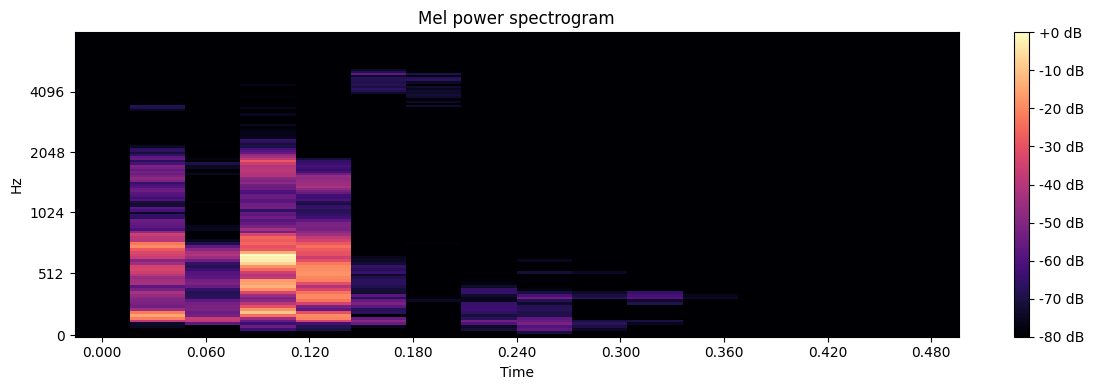

In [3]:
path = 'Inregistrari/Adi/approach_1.wav'

y, sr = librosa.load(path, sr = None, mono = True)
m = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
# print(m)
S = librosa.feature.melspectrogram(y = y, sr=sr, n_mels=128, n_fft=2048, hop_length=1024)
log_S = librosa.amplitude_to_db(S, ref = np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis = 'time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

#verificat dimensiune
#window si windo len in mfcc

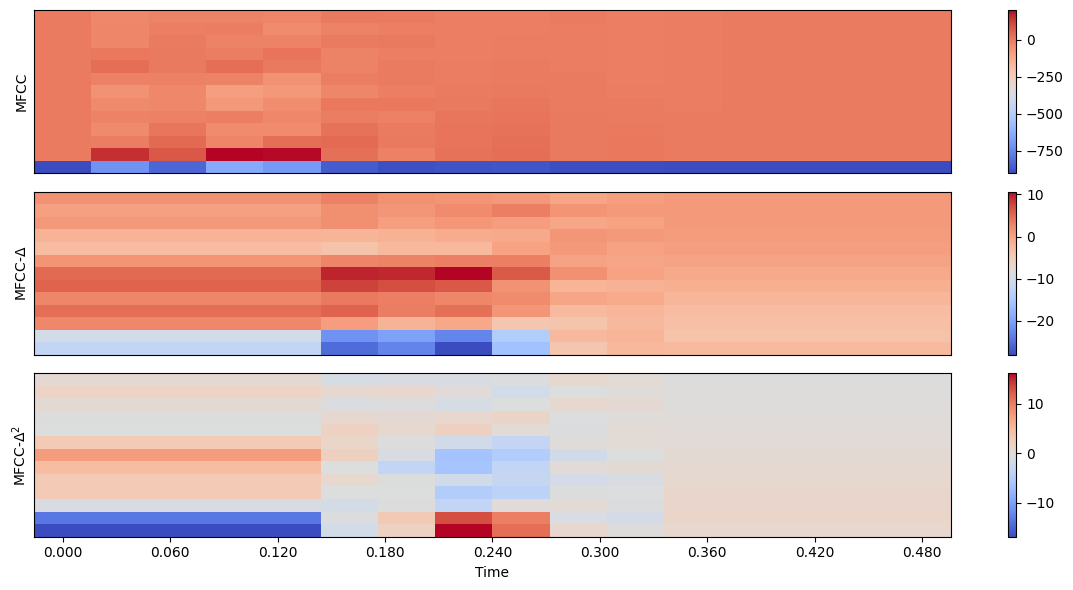

In [4]:
mfcc1 = librosa.feature.mfcc(S=log_S, n_mfcc=13)
#13, 32
delta_mfcc  = librosa.feature.delta(mfcc1)
delta2_mfcc = librosa.feature.delta(mfcc1, order=2)

plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc1)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

M = np.vstack([mfcc1, delta_mfcc, delta2_mfcc])

In [5]:
comprehensive_mfcc = np.concatenate((mfcc1, delta_mfcc, delta2_mfcc))
comprehensive_mfcc.shape

(39, 16)

In [6]:
classes = ['approach', 'start', 'stop', 'pick_up', 'free', 'home']

    Include mfcc to the dataloader 

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the dataset class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, set_number, sample_rate=16000, n_mfcc=13, n_mels=128):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        return [idx for idx in range(len(self.data)) if int(self.data.iloc[idx, 1]) == self.set_number]

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2])
        try:
            waveform, _ = librosa.load(file, sr=self.sample_rate)
            spectrogram = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=128, hop_length=128, n_fft=2048)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
            return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(class_label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            return self.__getitem__((idx + 1) % len(self.filtered_indices))  # Load next sample

# Load the datasets
csv_file = 'dataset.csv'
root_dir = 'Inregistrari'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)

In [9]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128
    

torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])


In [24]:

# Define the model
class ModifiedResNet(nn.Module):
    def __init__(self, base_model, num_classes=6):
        super(ModifiedResNet, self).__init__()
        self.base_model = base_model
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout for regularization

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.base_model.fc(x)
        return x

def get_resnet(version=18, freeze=False, num_classes=6, device='cpu', pretrained=True):
    weights = None if not pretrained else models.ResNet18_Weights.IMAGENET1K_V1
    resnet = models.__dict__[f'resnet{version}'](weights=weights)
    if freeze:
        for param in resnet.parameters():
            param.requires_grad = False
    model = ModifiedResNet(resnet, num_classes)
    return model.to(device)

In [11]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_resnet(version=18, num_classes=6, device=device)

In [19]:
import torch.optim as optim
import torch.nn as nn

# Assuming `model` is defined elsewhere
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:


# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    running_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

In [21]:


# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    
    test_losses = []
    test_accuracies = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    print(all)
    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [26]:
n_epoch = 10
log_interval = 20
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        
        torch.save(model.state_dict(), 'best_command_mfcc.pt')
        scheduler.step()
        pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/336 (0%)]	Loss: 0.014773


 10%|█         | 1/10 [00:12<01:48, 12.02s/it]

<built-in function all>

Test set: Average loss: 0.2551, Accuracy: 88/96 (92%)

Train Epoch: 2 [0/336 (0%)]	Loss: 0.041844


 10%|█         | 1/10 [00:18<02:43, 18.14s/it]


KeyboardInterrupt: 

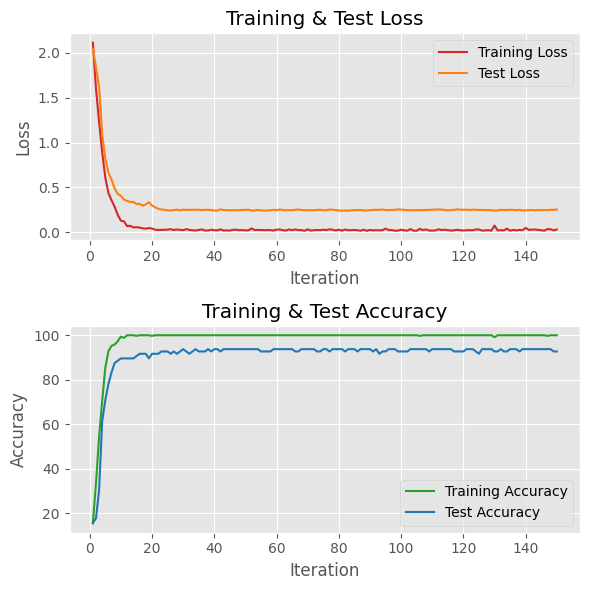

In [167]:
num_epochs = 150
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplo


# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_accuracies)], train_accuracies, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_accuracies)], test_accuracies, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()



In [170]:
from sklearn.metrics import classification_report

# Assuming the testing loop code here

# After the testing loop
report = classification_report(all_targets, all_preds, target_names=['start', 'stop', 'home', 'pick_up', 'approach', 'free'])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#normalize confusion matrix
confision_matrix = confision_matrix.astype('float') / confision_matrix.sum(axis=1)[:, np.newaxis]
print(confision_matrix)

              precision    recall  f1-score   support

       start       0.79      0.81      0.80      1800
        stop       0.90      0.83      0.86      3300
        home       0.87      0.99      0.93      2250
     pick_up       0.99      0.90      0.94      2850
    approach       0.98      0.99      0.98      2100
        free       0.91      0.97      0.94      2100

    accuracy                           0.91     14400
   macro avg       0.91      0.92      0.91     14400
weighted avg       0.91      0.91      0.91     14400

[[1463  297   19    0   12    9]
 [ 324 2736  192   24    9   15]
 [   3    3 2227    0    4   13]
 [  54    9   33 2571   17  166]
 [   0    1   18    0 2074    7]
 [   0    1   59    0    1 2039]]


In [171]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

In [169]:
def predict(tensor):
    if isinstance(tensor, np.ndarray):
        tensor = torch.from_numpy(tensor)
    
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    return tensor

nr = 0
for i in range(len(valid_dataset)):
    waveform, utterance = valid_dataset[i]
    if utterance != predict(waveform).item():
        nr += 1
        print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

print(nr)

Expected: 1. Predicted: 3.
Expected: 4. Predicted: 3.
Expected: 1. Predicted: 0.
Expected: 5. Predicted: 1.
Expected: 3. Predicted: 1.
Expected: 1. Predicted: 0.
6


    SPEAKER IDENTIFICATION

In [62]:
classes_pers = ['Adi', 'Anca', 'Bobo', 'Danila', 'Luci', 'Mada', 'Oana', 'Toni']

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the dataset class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, set_number, sample_rate=16000, n_mfcc=13, n_mels=128):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        return [idx for idx in range(len(self.data)) if int(self.data.iloc[idx, 1]) == self.set_number]

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        speaker_label = int(self.data.iloc[idx, 3]) 
        try:
            waveform, _ = librosa.load(file, sr=self.sample_rate)
            spectrogram = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=128, hop_length=128, n_fft=2048)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
            return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(speaker_label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            return self.__getitem__((idx + 1) % len(self.filtered_indices))  # Load next sample

# Load the datasets
csv_file = 'dataset.csv'
root_dir = 'Inregistrari'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)

In [64]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128
    

torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])


In [66]:

# Define the model
class ModifiedResNet(nn.Module):
    def __init__(self, base_model, num_classes=8):
        super(ModifiedResNet, self).__init__()
        self.base_model = base_model
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout for regularization

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.base_model.fc(x)
        return x

def get_resnet(version=18, freeze=False, num_classes=8, device='cpu', pretrained=True):
    weights = None if not pretrained else models.ResNet18_Weights.IMAGENET1K_V1
    resnet = models.__dict__[f'resnet{version}'](weights=weights)
    if freeze:
        for param in resnet.parameters():
            param.requires_grad = False
    model = ModifiedResNet(resnet, num_classes)
    return model.to(device)

In [67]:
model = get_resnet(version=18, num_classes=8, device=device)
# model.conv1 = torch.nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print(model)

ModifiedResNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [68]:
# Optimizer and loss function
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)  # Reduced learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()


In [74]:

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    train_losses = []
    train_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # data =data.repeat(1, 3, 1, 1)
        # data = data.squeeze(1)  # Remove channel dimension
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()
    return avg_loss, accuracy

In [75]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

all_preds = []
all_targets = []
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_losses = []
    test_accuracies = []
   
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # data = data.repeat(1, 3, 1, 1)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [76]:
n_epoch = 5
log_interval = 20

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        torch.save(model.state_dict(), 'best_speaker_mfcc.pt')
        pbar.update(1)


  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/336 (0%)]	Loss: 0.009767


 20%|██        | 1/5 [00:12<00:48, 12.03s/it]


Test set: Average loss: 0.2976, Accuracy: 84/96 (88%)

Train Epoch: 2 [0/336 (0%)]	Loss: 0.004147


 40%|████      | 2/5 [00:28<00:44, 14.89s/it]


Test set: Average loss: 0.4062, Accuracy: 84/96 (88%)

Train Epoch: 3 [0/336 (0%)]	Loss: 0.003682


 60%|██████    | 3/5 [00:44<00:29, 14.98s/it]


Test set: Average loss: 0.1204, Accuracy: 94/96 (98%)

Train Epoch: 4 [0/336 (0%)]	Loss: 0.066545


 80%|████████  | 4/5 [00:56<00:13, 13.98s/it]


Test set: Average loss: 0.0658, Accuracy: 94/96 (98%)

Train Epoch: 5 [0/336 (0%)]	Loss: 0.001933


100%|██████████| 5/5 [01:09<00:00, 13.88s/it]


Test set: Average loss: 1.1895, Accuracy: 77/96 (80%)



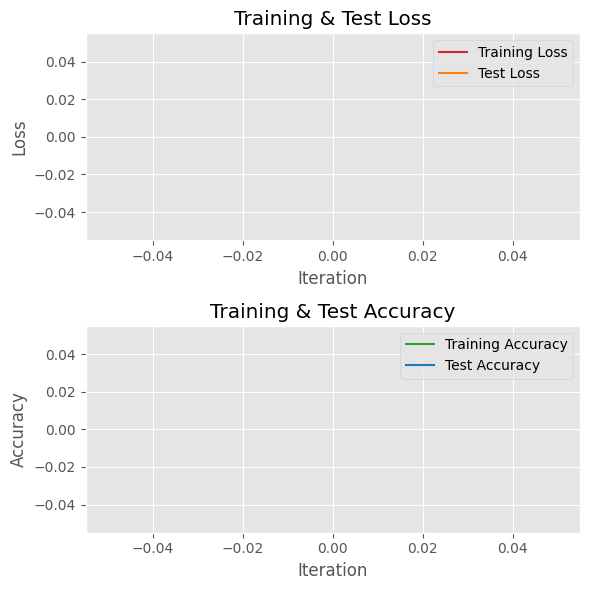

In [72]:
num_epochs = 150
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_losses_speaker)], train_losses_speaker, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_losses_speaker)], test_losses_speaker, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_accuracies_speaker)], train_accuracies_speaker, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_accuracies_speaker)], test_accuracies_speaker, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


              precision    recall  f1-score   support

    speaker1       1.00      0.89      0.94        45
    speaker2       0.92      0.96      0.94        50
    speaker3       0.95      0.98      0.97        60
    speaker4       0.97      0.83      0.89        75
  speaker1=5       0.90      1.00      0.95        55
    speaker6       0.83      0.95      0.89        65
    speaker7       0.81      0.87      0.84        60
    speaker8       0.89      0.79      0.83        70

    accuracy                           0.90       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.90      0.90       480

[[0.88888889 0.02222222 0.         0.         0.06666667 0.02222222
  0.         0.        ]
 [0.         0.96       0.         0.         0.04       0.
  0.         0.        ]
 [0.         0.         0.98333333 0.         0.01666667 0.
  0.         0.        ]
 [0.         0.         0.04       0.82666667 0.         0.13333333
  0.         0.   

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1ad801375d0>,
 None)

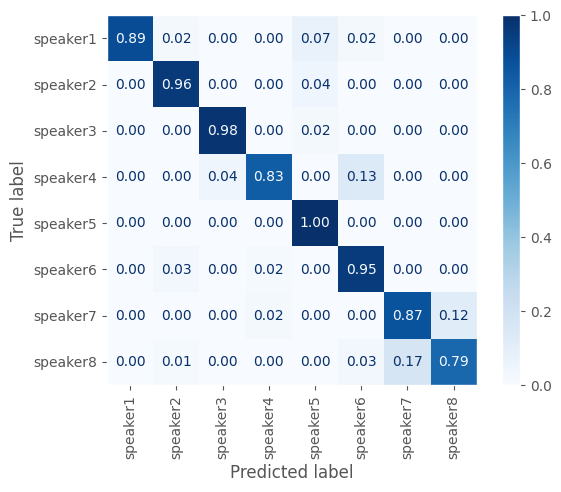

In [81]:
from sklearn.metrics import classification_report

report = classification_report(all_targets, all_preds, target_names=['speaker1', 'speaker2', 
                                                                     'speaker3', 'speaker4', 'speaker1=5', 'speaker6', 'speaker7', 'speaker8'])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#normalize confusion matrix
confision_matrix = confision_matrix.astype('float') / confision_matrix.sum(axis=1)[:, np.newaxis]
#print confusion matrix and labels
print(confision_matrix)


# confusion matrix display using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the confusion matrix is stored in the variable confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confision_matrix, display_labels=['speaker1', 'speaker2',
                                                                                  'speaker3', 'speaker4', 'speaker5', 'speaker6', 'speaker7', 'speaker8'])

#rempove the grid lines from the confusion matrix 
disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical', ax=None), plt.grid(False)


In [184]:
def predict(tensor):
    if isinstance(tensor, np.ndarray):
        tensor = torch.from_numpy(tensor)
    
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    return tensor

nr = 0
for i in range(len(valid_dataset)):
    waveform, utterance = valid_dataset[i]
    if utterance != predict(waveform).item():
        nr += 1
        print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

print(nr)

Expected: 5. Predicted: 4.
Expected: 3. Predicted: 7.
2
